<a href="https://colab.research.google.com/github/vaishveerkumar/Data-Science/blob/main/ML_Data_Cleaning_and_Prediction_Kaggle_Contributor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="border-radius:10px;border:black solid;padding: 15px;background-color:white;font-size:110%;text-align:left">
<div style="font-family:Georgia;background-color:'#DEB887'; padding:30px; font-size:17px">

   
CONTENT:<br><br>
1. [Libraries](#1)
2. [Data Load and General Overview](#2)
3. [Categorical Data - One Hot Encoding](#3)
4. [KNN Imputation for missing values](#4)
5. [Feature Selection](#6)
7. [Model](#8)    
</div>
</div>

<a id = "1"></a>
# Libraries

In [87]:
!pip install eli5
!pip install shap

import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance
import shap
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

<a id = "2"></a>
# Data Load and General Overview

In [98]:
# Loaded the given Kaggle datasets to git and pulling from there
train_data = pd.read_csv('https://raw.githubusercontent.com/vaishveerkumar/Data-Science/main/train.csv', index_col = 'Id')
test_data =  pd.read_csv('https://raw.githubusercontent.com/vaishveerkumar/Data-Science/main/test.csv', index_col = 'Id')


In [99]:
# copy data
df = train_data.copy()

In [90]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [91]:
df.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [119]:
import plotly.graph_objects as go

data_describe=df.describe()
summary_stats = data_describe.loc[['min', '25%', 'mean', '75%', 'max', 'std']]

fig = go.Figure()

for col in summary_stats.columns:
    fig.add_trace(go.Bar(
        x=summary_stats.index,
        y=summary_stats[col],
        name=col,
        hoverinfo='y+name',
    ))

fig.update_layout(
    barmode='group',
    title="Summary Statistics of Numeric Columns",
    xaxis_title="Numeric Columns",
    yaxis_title="Value",
)

fig.show()


# Checking for Missing Values

In [100]:
missing_values = df.isnull().sum().sort_values(ascending=False)
print("Total Missing Value Train Data :",missing_values.sum(),"\n")
print(missing_values)

missing_values_test = test_data.isnull().sum().sort_values(ascending=False)
print("Total Missing Values Test data :",missing_values_test.sum(),"\n")
print(missing_values_test)

Total Missing Value Train Data : 6965 

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
FireplaceQu     690
               ... 
Heating           0
HeatingQC         0
MSZoning          0
1stFlrSF          0
SalePrice         0
Length: 80, dtype: int64
Total Missing Values Test data : 7000 

PoolQC           1456
MiscFeature      1408
Alley            1352
Fence            1169
FireplaceQu       730
                 ... 
Electrical          0
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
SaleCondition       0
Length: 79, dtype: int64


# Impute Missing values using KNN imputer method

- Before proceeding with imputing missing values using the KNN imputer method, it's necessary to encode categorical data using the OneHotEncoder method. One-hot encoding is a process of converting categorical variables into a format that can be provided to machine learning algorithms to improve their predictive performance.

- Once the categorical variables are encoded, missing values can be imputed using the KNN imputer method. This method estimates missing values based on the values of other features (both categorical and numerical) using the K-nearest neighbors algorithm.

In [102]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

# Separate numerical and categorical features
numerical_features = df.select_dtypes(include=['float64', 'int64'])
categorical_features = df.select_dtypes(include=['object'])

# Impute missing values in numerical features using KNNImputer
imputer = KNNImputer()
numerical_imputed = pd.DataFrame(imputer.fit_transform(numerical_features), columns=numerical_features.columns)

# Encode categorical features into numerical representations
encoder = OneHotEncoder(handle_unknown='ignore')
categorical_encoded = pd.DataFrame(encoder.fit_transform(categorical_features).toarray(), columns=encoder.get_feature_names_out(categorical_features.columns))

# Concatenate the imputed numerical features with the encoded categorical features
df_imputed = pd.concat([numerical_imputed, categorical_encoded], axis=1)

# Verify the imputed dataset
print('Total Missing Value Train Data after imputation:', df_imputed.isnull().sum().sum())


Total Missing Value Train Data after imputation: 0


# Feature Selection





#Method1: Calculating the correlation coefficients between the 'SalePrice' column and  numerical columns

In [103]:
df.select_dtypes(exclude = 'object').corr()['SalePrice'].sort_values(ascending = False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

# Correlation Heatmap

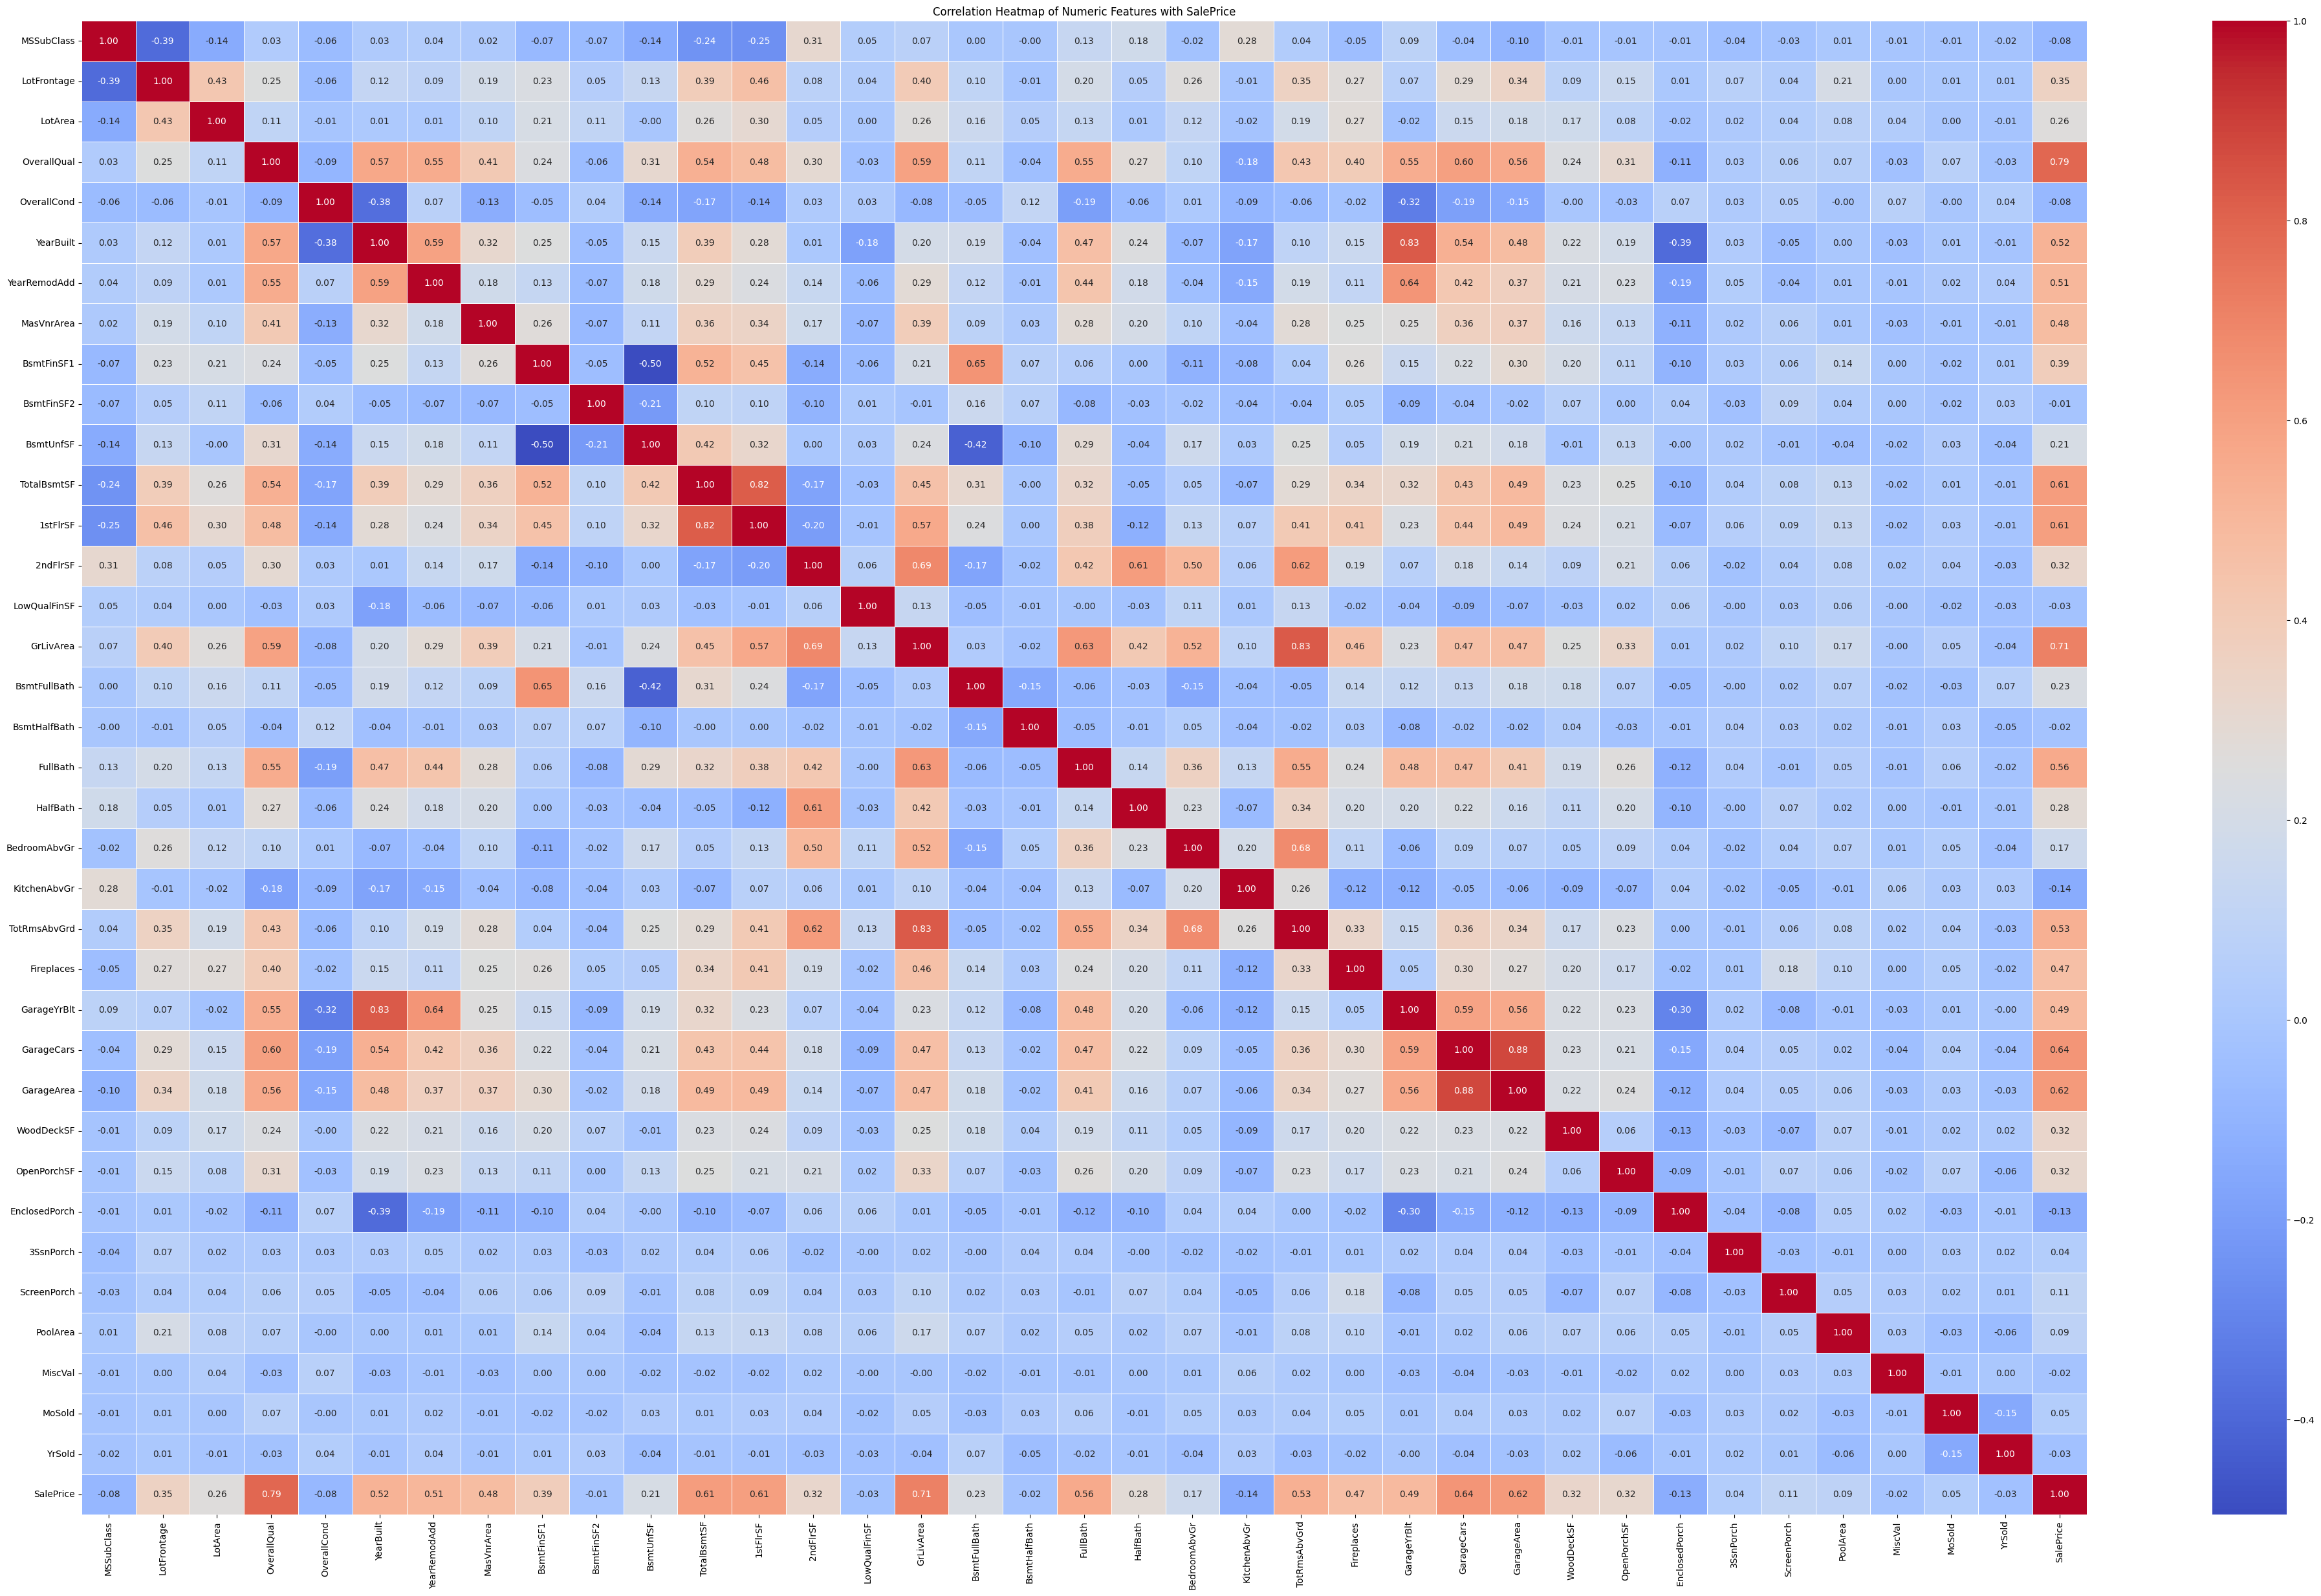

In [104]:
correlation_matrix = df.select_dtypes(exclude='object').corr()

# Sort correlation with 'SalePrice' in descending order
correlation_with_saleprice = correlation_matrix['SalePrice'].sort_values(ascending=False)

# Plot heatmap
plt.figure(figsize=(50, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features with SalePrice')
plt.show()

# Method2: Feature Importance from Tree-based Models:

- Random Forest is an ensemble learning method that combines the predictions from multiple decision trees. By aggregating the results from many trees, Random Forest tends to provide more stable and accurate predictions compared to individual decision trees.

In [111]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Assuming 'SalePrice' is the target variable
y_train = df_imputed['SalePrice']
X_train = df_imputed.drop(columns=['SalePrice'])

# Initialize the model
model = RandomForestRegressor()

# Fit the model
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Select top k features based on importance
k = 10
selected_feature_indices_importance = feature_importances.argsort()[-k:][::-1]
selected_feature_names_importance = X_train.columns[selected_feature_indices_importance]

# Print selected features along with their importance scores
print("Selected features using feature importance:")
for feature_name, importance_score in zip(selected_feature_names_importance, feature_importances[selected_feature_indices_importance]):
    print(f"{feature_name}: {importance_score}")



Selected features using feature importance:
OverallQual: 0.5816590169313322
GrLivArea: 0.10676851308068279
TotalBsmtSF: 0.03933501171606213
BsmtFinSF1: 0.03173423288588401
2ndFlrSF: 0.026381997160696245
GarageCars: 0.02345564292801763
1stFlrSF: 0.020332970098764575
GarageArea: 0.015980426103585476
LotArea: 0.01224639900037595
LotFrontage: 0.009526514445915573


#Inference
From both the correlation matrix and the Random Forest Feature selection we can see that the most imporatnt feature is **OverallQual** and **GrLivArea**

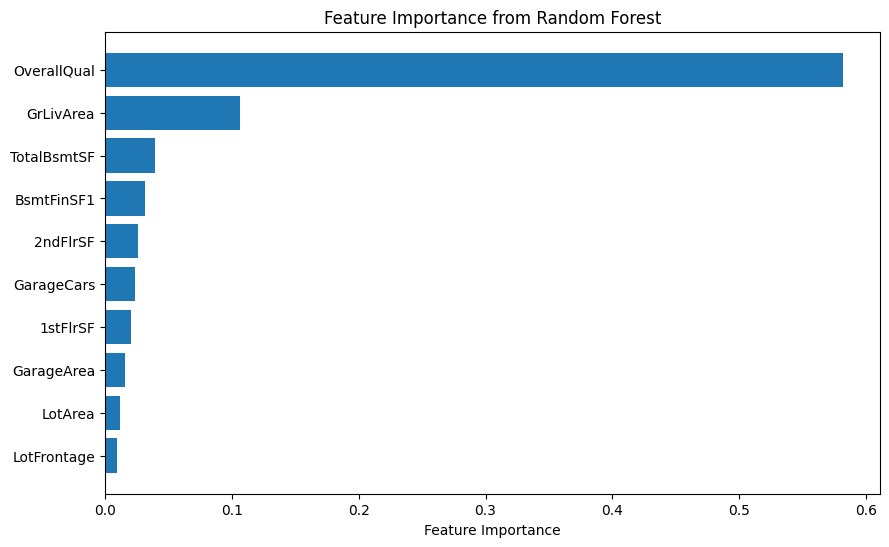

In [112]:
plt.figure(figsize=(10, 6))
plt.barh(range(len(selected_feature_names_importance)), feature_importances[selected_feature_indices_importance], align='center')
plt.yticks(range(len(selected_feature_names_importance)), selected_feature_names_importance)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()


# H20 AUTOML MODEL FOR PREDICTION

- Using H2O AutoML provides the advantage of automating the model selection and hyperparameter tuning process, potentially saving time and effort compared to manually selecting and tuning individual models. Additionally, it allows for the exploration of a wide range of machine learning algorithms and techniques, which can lead to better predictive performance

In [113]:
!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator

# Initialize H2O cluster
h2o.init()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 2.6 MB/s eta 0:00:00
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpr9mmmlgp
  JVM stdout: /tmp/tmpr9mmmlgp/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpr9mmmlgp/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_unknownUser_o9j3a7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [114]:
h2o_train = h2o.H2OFrame(df_imputed)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [117]:
h2o_test= h2o.H2OFrame(test_data)

X = h2o_train.columns
y = 'SalePrice'
X.remove(y)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Now that we have created a H2O frame of our test and train datasets we can create a H20 prediction model as below:

In [122]:
from h2o.automl import H2OAutoML

run_time=222

aml = H2OAutoML(max_runtime_secs=run_time, seed=1)  # Setting of AutoML
aml.train(x=X, y=y, training_frame=h2o_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_3_AutoML_1_20240327_43439


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    48                 48                          29330                  8            8            8             14            75            43.75

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 174879562.3625967
RMSE: 13224.203657029662
MAE: 7697.91020708476
RMSLE: 0.07092212875262081
Mean Residual Deviance: 174879562.3625967

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 821235537.4499491
RMSE: 28657.20742588065
MAE: 16437.90301917957
RMSLE: 0.13673055885615884
Mean Residual Deviance: 821235537.4499491

Cross-Validation Metrics Summary: 
                        mean        sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ----------  -----------  ------------  ------------  ------------  ------------  ------------
aic                     nan         0            nan           nan           nan           nan           nan
loglikelihood           nan         0            nan           nan           nan           nan           nan
mae                     16427.7     2081.87      14914.2       16278         16087.3       19969.2       14889.8
mean_residual_deviance  8.4452e+08  5.91051e+08  4.20168e+08   7.60155e+08   6.14487e+08   1.87887e+09   5.48919e+08
mse                     8.4452e+08  5.91051e+08  4.20168e+08   7.60155e+08   6.14487e+08   1.87887e+09   5.48919e+08
r2                      0.87368     0.0637276    0.921855      0.880033      0.898995      0.762853      0.904667
residual_deviance       8.4452e+08  5.91051e+08  4.20168e+08   7.60155e+08   6.14487e+08   1.87887e+09   5.48919e+08
rmse                    27926.5     8988.05      20498         27570.9       24788.9       43345.9       23429
rmsle                   0.135304    0.0192109    0.134112      0.124888      0.136461      0.166126      0.114933

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2024-03-27 04:36:57  15.362 sec  0                  79415.3          57434.8         6.30679e+09
    2024-03-27 04:36:58  15.734 sec  5                  52038.5          36432.1         2.70801e+09
    2024-03-27 04:36:58  16.152 sec  10                 35630            23814.3         1.2695e+09
    2024-03-27 04:36:58  16.577 sec  15                 26665.8          16676.7         7.11065e+08
    2024-03-27 04:36:59  17.021 sec  20                 21490.7          12726.5         4.61849e+08
    2024-03-27 04:36:59  17.475 sec  25                 18462.1          10525.3         3.40848e+08
    2024-03-27 04:37:00  17.842 sec  30                 16499.2          9277.12         2.72224e+08
    2024-03-27 04:37:00  18.161 sec  35                 15123.3          8599.83         2.28715e+08
    2024-03-27 04:37:00  18.418 sec  40                 14165.4          8155.51         2.0066e+08
    2024-03-27 04:37:00  18.615 sec  45                 13571.2          7857.26         1.84177e+08
    2024-03-27 04:37:01  18.716 sec  48                 13224.2          7697.91         1.7488e+08

Variable Importances: 
variable               relative_importance    scaled_importance     percentage
---------------------  ---------------------  --------------------  --------------------
OverallQual            16490666393600.0       1.0                   0.3795825287442996
ExterQual_TA           5771351818240.0        0.34997687058176447   0.132845

# Getting the best H20 AUTOML Model

In [123]:
bestmodel = aml.leaderboard
print (bestmodel)

model_id                                                   rmse          mse      mae     rmsle    mean_residual_deviance
GBM_3_AutoML_1_20240327_43439                           28657.2  8.21236e+08  16437.9  0.136731               8.21236e+08
StackedEnsemble_AllModels_1_AutoML_1_20240327_43439     28748.9  8.265e+08    16185    0.133817               8.265e+08
StackedEnsemble_BestOfFamily_2_AutoML_1_20240327_43439  28878.7  8.33977e+08  16254    0.134545               8.33977e+08
StackedEnsemble_BestOfFamily_3_AutoML_1_20240327_43439  28932.1  8.37069e+08  16062.9  0.134459               8.37069e+08
StackedEnsemble_AllModels_2_AutoML_1_20240327_43439     28998.8  8.40929e+08  16057.9  0.133314               8.40929e+08
GBM_4_AutoML_1_20240327_43439                           29542.8  8.72775e+08  16983.4  0.138122               8.72775e+08
GBM_5_AutoML_1_20240327_43439                           29645.8  8.78872e+08  16638.9  0.139444               8.78872e+08
GBM_2_AutoML_1_20240327_43

# Inference

Based on the leaderboard, **the Gradient Boosting Machine (GBM) model with ID "GBM_3_AutoML_1_20240327_43439**" seems to be the best-performing model, as it has the lowest RMSE (Root Mean Squared Error) among the models in the leaderboard

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning:

Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning:

Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()




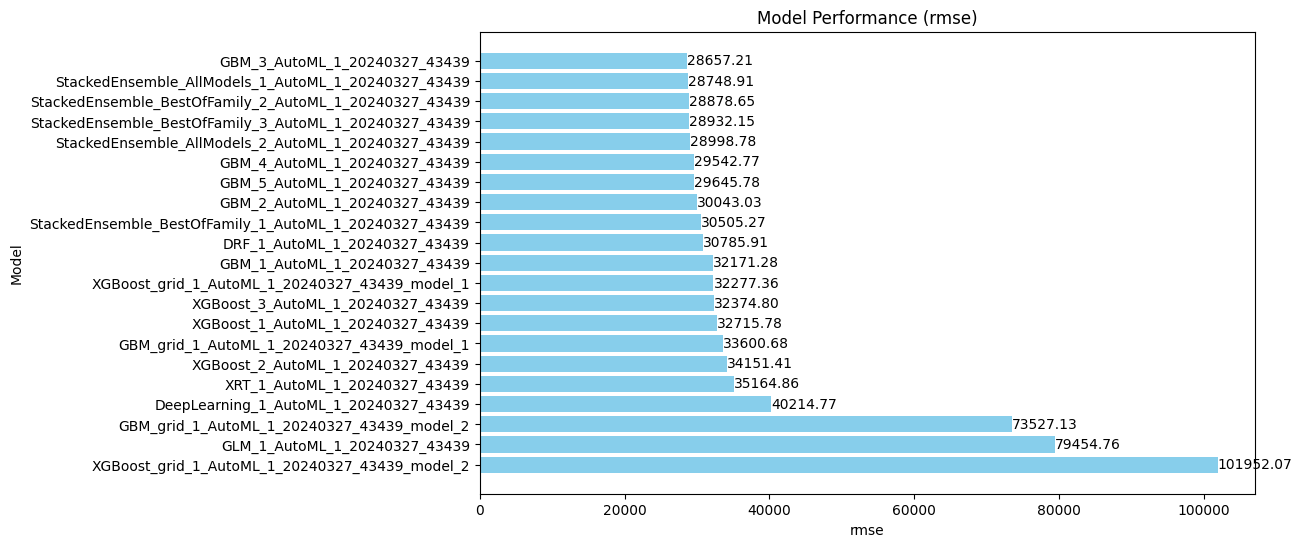

In [124]:
# Getting the model names and rmse values from the leaderboard
model_names = aml.leaderboard['model_id'].as_data_frame().values.flatten()
rmse = aml.leaderboard['rmse'].as_data_frame().values.flatten().astype(float)

# Plotting the leaderboard
plt.figure(figsize=(10, 6))
bars = plt.barh(model_names, rmse, color='skyblue')

# Adding labels
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}',
             va='center', ha='left', fontsize=10)

plt.xlabel('rmse')
plt.ylabel('Model')
plt.title('Model Performance (rmse)')

 # to get highest-performing model at the top
plt.gca().invert_yaxis()
plt.show()


# **Visualization of the Training and CV metrics**

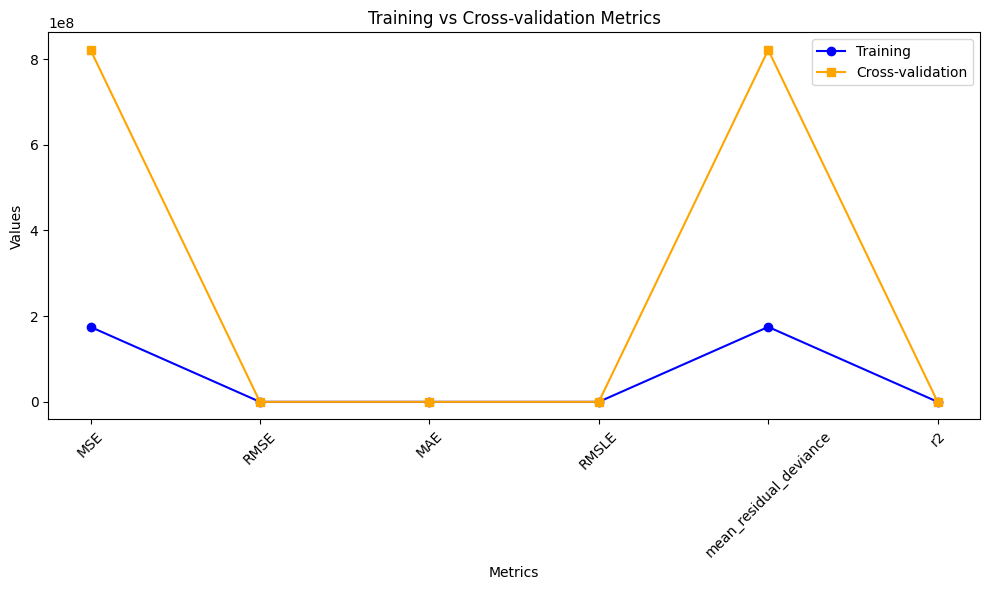

In [125]:
# Getting the best model
best_model = aml.leader

# training performance metrics
train_perf = best_model.model_performance(train=True)

# cross-validation performance metrics
cv_perf = best_model.model_performance(xval=True)

metrics = ['MSE', 'RMSE', 'MAE', 'RMSLE', 'mean_residual_deviance', 'r2']

train_values = [train_perf.mse(), train_perf.rmse(), train_perf.mae(), train_perf.rmsle(), train_perf.mean_residual_deviance(), train_perf.r2()]
cv_values = [cv_perf.mse(), cv_perf.rmse(), cv_perf.mae(), cv_perf.rmsle(), cv_perf.mean_residual_deviance(), cv_perf.r2()]

positions = range(len(metrics))

plt.figure(figsize=(10, 6))
plt.plot(positions, train_values, marker='o', label='Training', color='blue')
plt.plot(positions, cv_values, marker='s', label='Cross-validation', color='orange')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Training vs Cross-validation Metrics')
plt.legend()
plt.xticks(positions, metrics, rotation=45)
plt.tight_layout()
plt.show()


# **Inference - Model Performance and Graph**

The data has been divided into 5 folds and the model is trained and evaluated 5 times, each time using a different fold as the validation set and the remaining folds as the training set.

This allows us to assess the variability of the model's performance across different validation sets and provides a more robust estimate of the model's generalization performance compared to using a single train-test split.


**MSE (Mean Squared Error):**

The increase in MSE from training to CV suggests that the model fits the training data slightly better than it generalizes to unseen data.

**RMSE (Root Mean Squared Error):**

The RMSE is higher in CV indicating a loss in accuracy on unseen data.

**MAE (Mean Absolute Error):**

Again the MAE increases slightly in CV showing that the model's average absolute error is slightly higher on unseen data.

**RMSLE (Root Mean Squared Logarithmic Error):**

The increase in RMSLE from training to CV suggests that the model's logarithmic error is slightly higher on unseen data

**Mean Residual Deviance:**

The CV values indicates that the model's goodness of fit is reduced on unseen data

**R-squared:**

The values are high for both training and CV, indicating that the model explains nearly all the variance in both datasets.

**Null degrees of freedom and Residual degrees of freedom:**

These are degrees of freedom for the null model and residual model, respectively. They're related to the model's complexity and fit.

**Null deviance**

The high value suggests a significant potential for improvement when moving from a null model to a model with predictors.

**Residual deviance:**

 Residual Deviance measures the deviance of the fitted model from the actual data. A significant reduction from Null Deviance in both training and CV indicates that the model with predictors provides a substantial improvement in fit. The increase in Residual Deviance from training to CV suggests the model fits the training data better than it does unseen data.

**AIC (Akaike Information Criterion):**

The Null DoF corresponds to the intercept-only model, while the Residual DoF corresponds to the model with predictors. The difference between them indicates the number of predictors used in the model. The consistency of DoF between training and CV data, along with the slight reduction from Null to Residual, confirms the model complexity and the effective utilization of predictors


# **The values for each metric on the cross-validation data indicate of potential overfitting, that is the model performs marginally better on the training data than on the CV data.**

# **Make predictions on the testdata- h2o_test**

In [167]:
h2o_test

MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
20,RH,80,11622,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,CBlock,TA,TA,No,Rec,468,LwQ,144,270,882,GasA,TA,Y,SBrkr,896,0,0,896,0,0,1,0,2,1,TA,5,Typ,0,nan,Attchd,1961,Unf,1,730,TA,TA,Y,140,0,0,0,120,0,nan,MnPrv,nan,0,6,2010,WD,Normal
20,RL,81,14267,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108,TA,TA,CBlock,TA,TA,No,ALQ,923,Unf,0,406,1329,GasA,TA,Y,SBrkr,1329,0,0,1329,0,0,1,1,3,1,Gd,6,Typ,0,nan,Attchd,1958,Unf,1,312,TA,TA,Y,393,36,0,0,0,0,nan,nan,Gar2,12500,6,2010,WD,Normal
60,RL,74,13830,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,PConc,Gd,TA,No,GLQ,791,Unf,0,137,928,GasA,Gd,Y,SBrkr,928,701,0,1629,0,0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997,Fin,2,482,TA,TA,Y,212,34,0,0,0,0,nan,MnPrv,nan,0,3,2010,WD,Normal
60,RL,78,9978,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20,TA,TA,PConc,TA,TA,No,GLQ,602,Unf,0,324,926,GasA,Ex,Y,SBrkr,926,678,0,1604,0,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998,Fin,2,470,TA,TA,Y,360,36,0,0,0,0,nan,nan,nan,0,6,2010,WD,Normal
120,RL,43,5005,Pave,nan,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0,Gd,TA,PConc,Gd,TA,No,ALQ,263,Unf,0,1017,1280,GasA,Ex,Y,SBrkr,1280,0,0,1280,0,0,2,0,2,1,Gd,5,Typ,0,nan,Attchd,1992,RFn,2,506,TA,TA,Y,0,82,0,0,144,0,nan,nan,nan,0,1,2010,WD,Normal
60,RL,75,10000,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,763,763,GasA,Gd,Y,SBrkr,763,892,0,1655,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993,Fin,2,440,TA,TA,Y,157,84,0,0,0,0,nan,nan,nan,0,4,2010,WD,Normal
20,RL,nan,7980,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,7,1992,2007,Gable,CompShg,HdBoard,HdBoard,None,0,TA,Gd,PConc,Gd,TA,No,ALQ,935,Unf,0,233,1168,GasA,Ex,Y,SBrkr,1187,0,0,1187,1,0,2,0,3,1,TA,6,Typ,0,nan,Attchd,1992,Fin,2,420,TA,TA,Y,483,21,0,0,0,0,nan,GdPrv,Shed,500,3,2010,WD,Normal
60,RL,63,8402,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1998,1998,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,789,789,GasA,Gd,Y,SBrkr,789,676,0,1465,0,0,2,1,3,1,TA,7,Typ,1,Gd,Attchd,1998,Fin,2,393,TA,TA,Y,0,75,0,0,0,0,nan,nan,nan,0,5,2010,WD,Normal
20,RL,85,10176,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,7,5,1990,1990,Gable,CompShg,HdBoard,HdBoard,None,0,TA,TA,PConc,Gd,TA,Gd,GLQ,637,Unf,0,663,1300,GasA,Gd,Y,SBrkr,1341,0,0,1341,1,0,1,1,2,1,Gd,5,Typ,1,Po,Attchd,1990,Unf,2,506,TA,TA,Y,192,0,0,0,0,0,nan,nan,nan,0,2,2010,WD,Normal
20,RL,70,8400,Pave,nan,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,CBlock,TA,TA,No,ALQ,804,Rec,78,0,882,GasA,TA,Y,SBrkr,882,0,0,882,1,0,1,0,2,1,TA,4,Typ,0,nan,Attchd,1970,Fin,2,525,TA,TA,Y,240,0,0,0,0,0,nan,MnPrv,nan,0,4,2010,WD,Normal


In [160]:
X_test = h2o_test

predictions = best_model.predict(X_test)

predictions_df = predictions.as_data_frame()

actual_values_df = df_imputed['SalePrice']

#Adding the actual SalePrice to the dataframe that contains the predicted ones

predictions_df['Actual_SalePrice'] = actual_values_df

print(predictions_df.head())


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
         predict  Actual_SalePrice
0  129448.559170          208500.0
1  157871.352971          181500.0
2  168093.440114          223500.0
3  179674.704957          140000.0
4  189552.366356          250000.0


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning:

Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()




In [163]:
from sklearn.metrics import mean_absolute_error

# Extract predicted and actual SalePrice values from predictions_df
predicted_values = predictions_df['predict']
actual_values = predictions_df['Actual_SalePrice']

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predicted_values)
print("Mean Absolute Error (MAE):", mae)


Mean Absolute Error (MAE): 75323.6037344415


**A MAE of approximately 75323.60 implies that, on average, the model's predictions deviate from the actual SalePrice values by approximately $75,323.60.**

In [181]:
ids = pd.Series(range(1, len(predictions_df) + 1))

# Create a DataFrame with predicted values and Ids
predictions_with_ids_df = pd.concat([ids, predictions_df['predict']], axis=1)

# Rename columns for clarity
predictions_with_ids_df.columns = ['Id', 'SalePrice']

print(predictions_with_ids_df.head())


   Id      SalePrice
0   1  129448.559170
1   2  157871.352971
2   3  168093.440114
3   4  179674.704957
4   5  189552.366356


In [ ]:
# Save DataFrame to CSV file in Google Colab
predictions_with_ids_df.to_csv('predictions_with_ids.csv', index=False)

# Download the CSV file
from google.colab import files
files.download('predictions_with_ids.csv')
